<a href="https://colab.research.google.com/github/chinmay5/NLP-Praktikum/blob/sentence_embedding/Classification_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pandas import Series
from google.colab import drive
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from tensorflow import summary
from torch.utils.data import BatchSampler
from collections import Counter
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report
from torch.utils.tensorboard import SummaryWriter
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [0]:
# Dictionary for label to index, this has been pre-generated
encoding_to_labels = {
   0:	"Amazon Instant Videos",
   1 :"Android Apps",
   2 : "Automotive",
   3 :"Baby",
   4 :"Beauty",
   5 :"CDs and Vinyl",
   6 :"Cell Phones and Accessories",
   7 :"Clothing, Shoes, Jewelry",
   8 :"Digital Music",
   9 :"Electronics",
  10 :"Grocery and Gourmet",
  11 :"Health and Personal Care",
  12 :"Home and Kitchen",
  13 :"Kindle",
  14 :"Movies and TV",
  15 :"Musical Instruments",
  16 :"Office Products",
  17 :"Patio Garden",
  18 :"Pet Supplies",
  19 :"Sports, Outdoors",
  20 :"Tool and Home Improvement",
  21 :"Toys_and_Games",
  22 :"Video Games"
}

In [0]:
def get_lebel_from_code(code):
  if code not in encoding_to_labels.keys():
    raise KeyError("Invalid Code")
  return encoding_to_labels[code]

def get_all_labels():
  return list(encoding_to_labels.values())

In [0]:
!pip install -q tb-nightly

In [0]:
# # Delete any old logs.... be smart while using this
% rm -rf /content/logs/

In [0]:
% mkdir -p '/content/logs/tensorboard/train/'
% mkdir -p '/content/logs/tensorboard/val/'

In [0]:
%load_ext tensorboard

#Read the Data

In [15]:
# Run this cell to mount your Google Drive.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [16]:
%cd /content/
test_data = pd.read_pickle('/content/drive/My Drive/dtest_20k_accuracytest_encoded_labelsmappedandreduced.pkl')

/content


In [17]:
test_data.head()

,sentence_embedding,labels_encoded
0,"[[0.020630155, -5.427392e-05, -0.0005429585, 0...",2
1,"[[0.009404534, -0.00013506821, 0.0029931439, 0...",2
2,"[[0.0118809715, -1.7096989e-05, 0.017329859, 0...",2
3,"[[0.013619319, -0.000120394856, -0.00017446173...",2
4,"[[0.013776152, 0.0014088053, 0.0023799718, 0.0...",2


In [18]:
len(test_data)
# test_data.columns

13184

In [0]:
def random_selection(data_frame, num_samples):
  sampled_df = data_frame.sample(n=num_samples)
  return sampled_df

In [20]:
class_list = set(test_data.labels_encoded)
class_list

{0, 1, 2, 3, 5, 7, 8, 9, 13, 14, 15, 19, 21, 22}

In [21]:
df_per_class_dict = dict()
for label_type in class_list:
    df_per_class_dict[label_type] = test_data[test_data.labels_encoded == label_type]
    
df_per_class_dict.keys() 

dict_keys([0, 1, 2, 3, 5, 7, 8, 9, 13, 14, 15, 19, 21, 22])

In [22]:
for key, val in df_per_class_dict.items():
  print("Key has {} and length of list is {}".format(key, len(val)))

Key has 0 and length of list is 999
Key has 1 and length of list is 999
Key has 2 and length of list is 402
Key has 3 and length of list is 794
Key has 5 and length of list is 999
Key has 7 and length of list is 999
Key has 8 and length of list is 999
Key has 9 and length of list is 999
Key has 13 and length of list is 999
Key has 14 and length of list is 999
Key has 15 and length of list is 999
Key has 19 and length of list is 999
Key has 21 and length of list is 999
Key has 22 and length of list is 999


In [0]:
num_samples_per_class = 10

In [0]:
# https://pandas.pydata.org/pandas-docs/version/0.18/merging.html
def create_random_frame(df_per_class, num_samples):
    list_of_seed_df = []
    list_of_test_df = []
    for cat,data_frame_of_class in df_per_class.items():
        random_df = random_selection(data_frame_of_class, num_samples)
        # https://stackoverflow.com/questions/42363706/how-to-extract-rows-in-a-pandas-dataframe-not-in-a-subset-dataframe
        extract_idx = list(set(data_frame_of_class.index) - set(random_df.index))
        remaining_terms = data_frame_of_class.loc[extract_idx]
        list_of_seed_df.append(random_df)
        list_of_test_df.append(remaining_terms)
    train_set_df = pd.concat(list_of_seed_df)
    test_set_df = pd.concat(list_of_test_df)
    return train_set_df, test_set_df

In [0]:
train_df, test_df = create_random_frame(df_per_class_dict, num_samples_per_class)

In [45]:
train_df.groupby(train_df.labels_encoded).count()

,sentence_embedding
labels_encoded,
0,10
1,10
2,10
3,10
5,10
7,10
8,10
9,10
13,10


In [46]:
test_df.groupby(test_df.labels_encoded).count()

,sentence_embedding
labels_encoded,
0,989
1,989
2,392
3,784
5,989
7,989
8,989
9,989
13,989


In [47]:
(train_df.sentence_embedding.isin(test_df.sentence_embedding)).sum() == 0

True

# The three networks that need to be loaded

In [0]:
class TripletNetwork(nn.Module):
    
    def __init__(self):
        super(TripletNetwork, self).__init__()

        self.input_dim=1024
        self.fc = nn.Sequential(nn.Linear(1024, 512),
                                  nn.BatchNorm1d(num_features=512),
                                  nn.ReLU(),
                                  #nn.Dropout(),
                                  nn.Linear(512,256),
                                  nn.BatchNorm1d(num_features=256),
                                  nn.ReLU(),
                                  #nn.Dropout(p=0.6),
                                  nn.Linear(256,64) #earlier 64
                               )
       
    def forward(self, x1, x2, x3):
       
        """
          We updated the network now and are directly getting the sentence embeddings
        """
        # These are the embeddings and what we want to achieve is to make
        # these embeddings which should be in the same region denoting their language to
        # fall a bit away based on the task at hand
        output1 = self.fc(x1.cuda())
        output2 = self.fc(x2.cuda())
        output3 = self.fc(x3.cuda())
        
        return (output1, output2, output3)

    def get_embedding(self, x):
        return self.encoder.encode_sentences(sentences = x)

In [0]:
class ClassificationNet(nn.Module):
  

  def __init__(self, embedding_network, num_classes):
    super(ClassificationNet, self).__init__()
    self.embedding_network = embedding_network #We would like to freeze these embeddings
    self.num_classes = num_classes
    self.nonlinear = nn.ReLU()
    self.fc1 = nn.Linear(64, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, self.num_classes)
    # Freeze the weights of this network
    """ This attempt is to first allow classification network to train"""
    for param in self.embedding_network.fc.parameters():
           param.requires_grad = False
    
  

  def forward(self,x):
    x = self.embedding_network.fc(x)
    x = self.fc1(self.nonlinear(x))
    x = self.fc2(self.nonlinear(x))
    x = self.fc3(self.nonlinear(x))
    return x

In [0]:
# We need to define a specific dataloader in this case, which shall be frankly, quite simple and dummy
class SoftmaxDataset(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset, select_column):
         
        
        self.dataset = dataset
        self.train_labels = self.dataset.labels_encoded
            # Drop the labels column so that remaining features form part of the training set
        self.dataset = self.dataset.drop('labels_encoded', axis=1)
        self.train_data = self.dataset
        self.select_column = select_column
       
    def __getitem__(self, index):
        #print(type(self.train_data))
        selected_frame, label = self.train_data.iloc[index], self.train_labels.iloc[index]
        str_data = selected_frame[self.select_column]

        return str_data, label

    def __len__(self):
        return len(self.dataset)

# Classification Network

In [0]:
# Global declarations
num_classes=23
num_epochs = 200
batch_size = 100

In [77]:
# Load a pre-existing model 
PATH = '/content/11-model-GOOD.pth'
model = TripletNetwork()
model.load_state_dict(torch.load(PATH))
model.cuda()

TripletNetwork(
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [78]:
num_classes = max(set(train_df.labels_encoded)) + 1
net = ClassificationNet(embedding_network=model, num_classes=num_classes)
net.cuda()

ClassificationNet(
  (embedding_network): TripletNetwork(
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (nonlinear): ReLU()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=23, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [0]:
softmax_train_dataset = SoftmaxDataset(dataset=train_df,select_column='sentence_embedding')
softmax_test_dataset = SoftmaxDataset(dataset=test_df,select_column='sentence_embedding')
# Now the dataloaders need to be defined as well
classification_train_loader = DataLoader(softmax_train_dataset, batch_size=batch_size,shuffle=True)
classification_test_loader = DataLoader(softmax_test_dataset, batch_size=batch_size,shuffle=True)

In [0]:
train_writer = SummaryWriter('/content/logs/tensorboard/train/')
val_writer = SummaryWriter('/content/logs/tensorboard/val/')

In [82]:
# Next we need to train this network in order to learn the weights of the fc layer and cross entropy weights
for epoch in range(num_epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(classification_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        #reshape the input to align
        batch_size = inputs.shape[0]
        inputs = inputs.reshape(batch_size,-1)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Write the scalars
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).cpu().sum().item()
    print("loss is {}".format(running_loss/total))   
    print('Accuracy of the network on the train samples: {} '.format((100 * correct / total)))
    train_writer.add_scalar('Loss', running_loss/total,epoch)
    train_writer.add_scalar('Accuracy', 100*correct/total,epoch)
    # Now this is the section for testing the model in the same epoch
    correct = 0
    total = 0
    loss_val = 0
    with torch.no_grad():
        for data in classification_test_loader:
            inputs, labels = data
            inputs = inputs.cuda()
            batch_size = inputs.shape[0]
            inputs = inputs.reshape(batch_size,-1)
            # Next the evaluation
            outputs = net(inputs)
            labels = labels.cuda()
            loss = criterion(outputs, labels)
            loss_val = loss_val + loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).cpu().sum().item()
            
    print('Accuracy of the network on the test samples:{}'.format(
        (100 * correct / total)))
    print("epoch is {} loss validation set is {}".format(epoch, loss_val/total)) 
    torch.save(net.state_dict(), '/content/{}-classifier.pth'.format(epoch))
    val_writer.add_scalar('Loss', loss_val/total,epoch)
    val_writer.add_scalar('Accuracy', 100*correct/total,epoch)
print('Finished Training')

loss is 0.04459913969039917
Accuracy of the network on the train samples: 7.857142857142857 
Accuracy of the network on the test samples:5.136461208218338
epoch is 0 loss validation set is 0.03140084645163973
loss is 0.04440448795046125
Accuracy of the network on the train samples: 5.0 
Accuracy of the network on the test samples:5.749770009199632
epoch is 1 loss validation set is 0.031244066148329204
loss is 0.04383443934576852
Accuracy of the network on the train samples: 11.428571428571429 
Accuracy of the network on the test samples:7.727690892364305
epoch is 2 loss validation set is 0.031082401810084263
loss is 0.0435438905443464
Accuracy of the network on the train samples: 12.142857142857142 
Accuracy of the network on the test samples:9.306961054891138
epoch is 3 loss validation set is 0.030912430529139664
loss is 0.04333219528198242
Accuracy of the network on the train samples: 14.285714285714286 
Accuracy of the network on the test samples:9.858938975774302
epoch is 4 loss va

In [83]:
%tensorboard --logdir /content/logs/tensorboard

UsageError: Line magic function `%tensorboard` not found.


# The Classification Dataset Evaluation

In [84]:
# First load the best model based on the classification scenario above
net = ClassificationNet(embedding_network=model, num_classes=num_classes)
PATH = '/content/126-classifier.pth'
net.load_state_dict(torch.load(PATH))
net.cuda()

ClassificationNet(
  (embedding_network): TripletNetwork(
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (nonlinear): ReLU()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=23, bias=True)
)

In [0]:
# TODO: Still not ready. Please refer to the KNN part for now
all_labels = []
all_predictions=[]
with torch.no_grad():
    for data in classification_test_loader:
        inputs, labels = data
        inputs = inputs.cuda()
        batch_size = inputs.shape[0]
        inputs = inputs.reshape(batch_size,-1)
        # Next the evaluation
        outputs = net(inputs)
        labels = labels.cuda()
        loss = criterion(outputs, labels)
        loss_val = loss_val + loss.item()
        _, predicted = torch.max(outputs.data, 1)
        for idx in range(batch_size):
            all_predictions.append(predicted[idx].item())
            all_labels.append(labels[idx].item())


In [0]:
labels = list(set(train_df.labels_encoded))
cm = confusion_matrix(all_labels, all_predictions, labels)

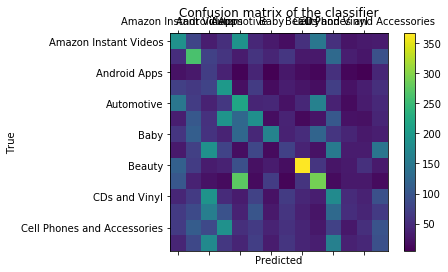

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + get_all_labels())
ax.set_yticklabels([''] + get_all_labels())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

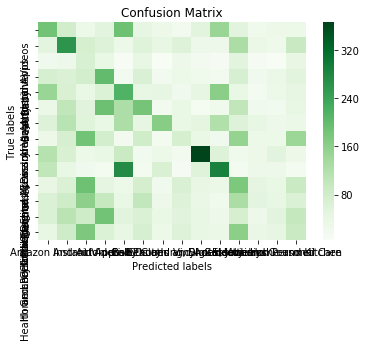

In [89]:
ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([''] + get_all_labels());
ax.yaxis.set_ticklabels([''] + get_all_labels());

In [90]:
print(classification_report(all_labels, all_predictions,labels=labels, target_names=get_all_labels()))

                             precision    recall  f1-score   support

      Amazon Instant Videos       0.18      0.19      0.18       989
               Android Apps       0.21      0.27      0.23       989
                 Automotive       0.06      0.18      0.09       392
                       Baby       0.17      0.26      0.20       784
                     Beauty       0.17      0.22      0.19       989
              CDs and Vinyl       0.20      0.19      0.19       989
Cell Phones and Accessories       0.29      0.17      0.21       989
   Clothing, Shoes, Jewelry       0.13      0.08      0.09       989
              Digital Music       0.42      0.37      0.39       989
                Electronics       0.29      0.29      0.29       989
        Grocery and Gourmet       0.14      0.18      0.16       989
   Health and Personal Care       0.12      0.05      0.07       989
           Home and Kitchen       0.11      0.05      0.07       989
                     Kindle      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1870: UserWarning: labels size, 14, does not match size of target_names, 23
  .format(len(labels), len(target_names))


# Now the Nearest Neighbour Part

In [0]:
# We need to define a specific dataloader in this case, which shall be frankly, quite simple and dummy
class TestDataset(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset, select_column):
         
        
        self.dataset = dataset
        self.train_labels = self.dataset.labels_encoded
            # Drop the labels column so that remaining features form part of the training set
        self.dataset = self.dataset.drop('labels_encoded', axis=1)
        self.train_data = self.dataset
        self.select_column = select_column
       
    def __getitem__(self, index):
        #print(type(self.train_data))
        selected_frame, label = self.train_data.iloc[index], self.train_labels.iloc[index]
        str_data = selected_frame[self.select_column]

        return str_data, label

    def __len__(self):
        return len(self.dataset)

In [0]:
# Global declarations
batch_size = 100

In [0]:
one_shot_train_dataset = SoftmaxDataset(dataset=train_df,select_column='sentence_embedding')
one_shot_test_dataset = SoftmaxDataset(dataset=test_df,select_column='sentence_embedding')
# Now the dataloaders need to be defined as well
one_shot_train_loader = DataLoader(one_shot_train_dataset, batch_size=batch_size,shuffle=True)
one_shot_test_loader = DataLoader(one_shot_test_dataset, batch_size=batch_size,shuffle=True)

In [53]:
# Load a pre-existing model 
PATH = '/content/11-model-GOOD.pth'
model = TripletNetwork()
model.load_state_dict(torch.load(PATH))
model.cuda()

TripletNetwork(
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [0]:
embedding_model = model

In [0]:
# Let us save the embedding of all elements in the train_data as well as their index
# this can be used later for our purpose
embedding_space_one_shot = []
for i, data in enumerate(one_shot_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        batch_size = inputs.shape[0]
        inputs = inputs.reshape(batch_size,-1)
        labels = labels.cuda()
        embeddings = embedding_model.fc(inputs)
        for index,tensor in enumerate(embeddings):
           embedding_space_one_shot.append((labels[index],tensor))

In [56]:
y_train = []
dist = []
for index,space in embedding_space_one_shot[:-1]:
  dist.append(space)
  y_train.append(index.item())
# dist = [space for index,space in embedding_space_one_shot[:-1]]
result = torch.stack(dist, dim=0)
result.shape

torch.Size([139, 64])

In [0]:
#select the norm
def select_norm(vector_x, power=2):
  return torch.norm(vector_x,p=power,dim=1)

In [0]:
def k_nearest_neighbour(distance_embeddings, vector, k=3):  
    updated_result = select_norm(vector_x=(distance_embeddings - vector), power=2)
    values, indices = torch.topk(updated_result,k=k ,largest=False)
    candidate_indexes = []
    for index in indices:
      candidate_indexes.append((embedding_space_one_shot[index][0]).item())
    return Counter(candidate_indexes).most_common(1)[0][0]

In [59]:
correct = 0
total = 0
all_labels = []
all_predictions_one_shot=[]
for data in one_shot_test_loader:
    inputs, labels = data
    inputs = inputs.cuda()
    batch_size = inputs.shape[0]
    inputs = inputs.reshape(batch_size,-1)
    # Next the evaluation
    
    output = embedding_model.fc(inputs)
    for idx,query in enumerate(output):
        predicted = k_nearest_neighbour(result, query, 5)
#         print(labels[idx])
#         print(predicted)
        all_predictions_one_shot.append(predicted)
        correct += (predicted == labels[idx])
        all_labels.append(labels[idx].item())
    total += labels.size(0)
    correct = correct.cpu().sum()
print('Accuracy of the network on the test samples: %d %%' % (
        100 * correct /total))

Accuracy of the network on the test samples: 16 %


In [60]:
f1_score(all_labels, all_predictions_one_shot, average='micro') 

0.16781662066850658

In [61]:
f1_score(all_labels, all_predictions_one_shot, average='macro') 

0.15600969518466257

In [0]:
labels = list(set(train_df.labels_encoded))
cm = confusion_matrix(all_labels, all_predictions_one_shot, labels)

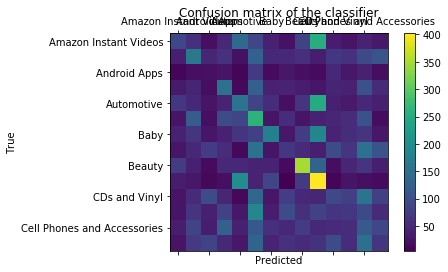

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + get_all_labels())
ax.set_yticklabels([''] + get_all_labels())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

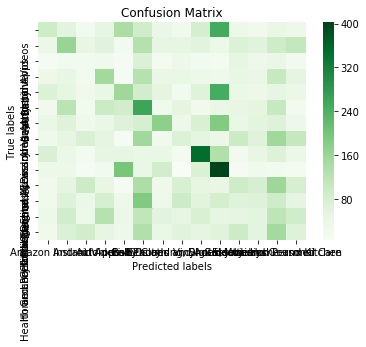

In [65]:
ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([''] + get_all_labels());
ax.yaxis.set_ticklabels([''] + get_all_labels());

In [66]:
accuracy_score(all_labels, all_predictions_one_shot)

0.16781662066850658

In [67]:
print(classification_report(all_labels, all_predictions_one_shot,labels=labels, target_names=get_all_labels()))

                             precision    recall  f1-score   support

      Amazon Instant Videos       0.16      0.09      0.12       989
               Android Apps       0.18      0.17      0.17       989
                 Automotive       0.04      0.06      0.05       392
                       Baby       0.17      0.20      0.18       784
                     Beauty       0.18      0.16      0.17       989
              CDs and Vinyl       0.16      0.26      0.20       989
Cell Phones and Accessories       0.24      0.18      0.20       989
   Clothing, Shoes, Jewelry       0.11      0.07      0.09       989
              Digital Music       0.32      0.35      0.34       989
                Electronics       0.25      0.41      0.31       989
        Grocery and Gourmet       0.12      0.09      0.10       989
   Health and Personal Care       0.10      0.07      0.08       989
           Home and Kitchen       0.09      0.12      0.10       989
                     Kindle      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1870: UserWarning: labels size, 14, does not match size of target_names, 23
  .format(len(labels), len(target_names))
